In [1]:
%pip install mlflow
%pip install neuralforecast
%pip install statsforecast
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from sklearn.metrics import r2_score
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast
import pickle
from lightgbm import LGBMRegressor

In [3]:
%cd /teamspace/studios/this_studio/2024/06/MLFlow_TimeSeries_Forecast

/teamspace/studios/this_studio/2024/06/MLFlow_TimeSeries_Forecast


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
mlflow.set_tracking_uri("http://0.0.0.0:5000")

# Load Data

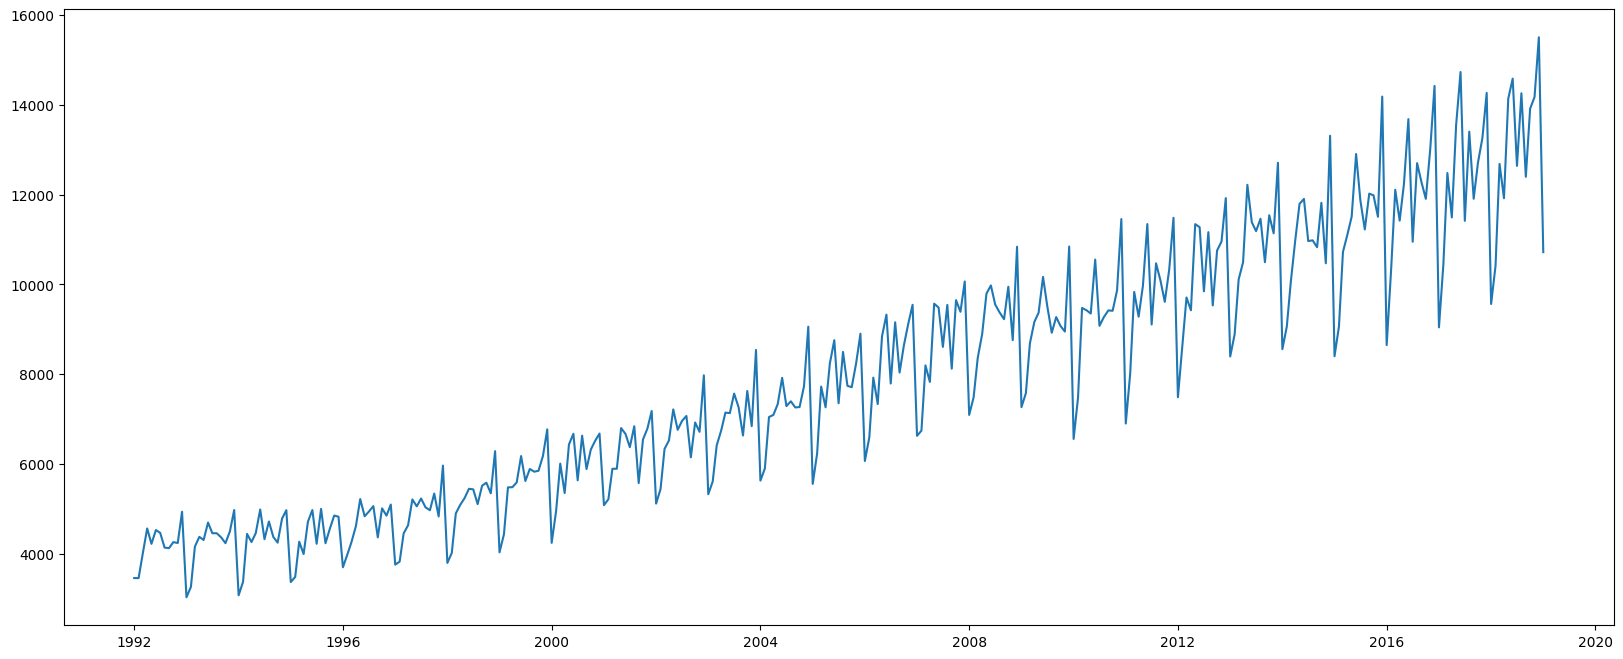

In [5]:
df = pd.read_csv('/teamspace/uploads/Alcohol_Sales.csv',index_col=0,parse_dates=True)
plt.figure(figsize=(20,8))
plt.plot(df)
plt.show()

# Train Test Split

In [6]:
def train_test_split(data,test_size=12):
    train = data[:-12]
    test = data[-12:]
    return train,test 

def process_data(data):
    data = data.reset_index()
    data.columns = ['ds','y']
    data['unique_id'] = 'Alcohol_Sale'
    return data

def show_train_test(train,test):
    plt.figure(figsize=(20,8))
    plt.plot(train.index,train['y'],label='Training Data')
    plt.plot(test.index,test['y'],label='Test Data')
    plt.show()

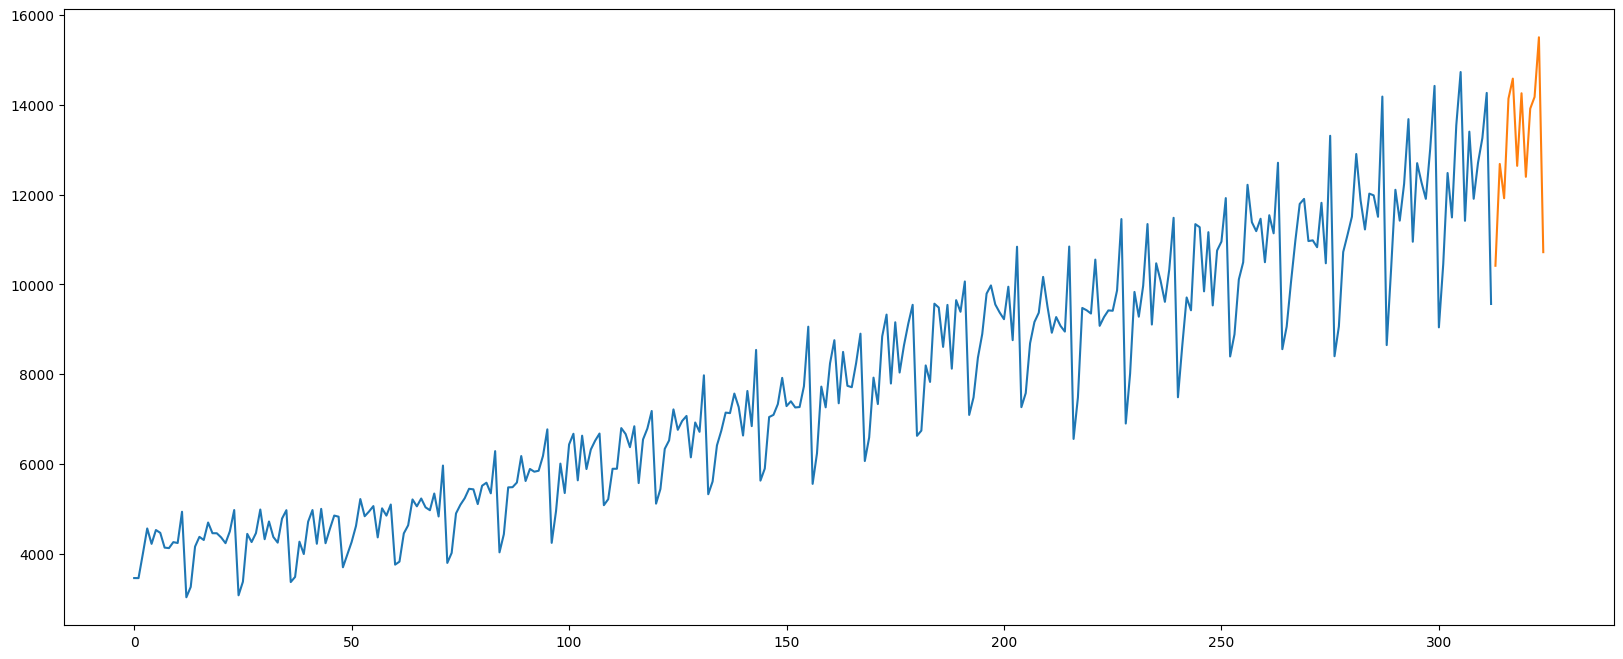

In [7]:
df_processed = process_data(df)
train,test = train_test_split(df_processed)
show_train_test(train,test)

In [30]:
mk = Forecasting_Model('AutoARIMA',train,test,season_length=12)

In [31]:
mk.fit()

In [32]:
mk.forecast(12)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


array([10651.729 , 12380.003 , 12028.163 , 13840.737 , 14699.921 ,
       12286.267 , 13443.771 , 12330.133 , 13289.814 , 13232.215 ,
       14683.4795, 10088.414 ], dtype=float32)

In [33]:
mk.wmape()

[10415 12683 11919 14138 14583 12640 14257 12396 13914 14174 15504 10718]
[10651.729  12380.003  12028.163  13840.737  14699.921  12286.267
 13443.771  12330.133  13289.814  13232.215  14683.4795 10088.414 ]


0.03376093018110346

In [19]:
y_pred = mk.forecast(12)
y_true = test['y'].values

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [22]:
np.abs(y_true-y_pred)/np.sum(y_true)

array([0.00150456, 0.00192573, 0.0006938 , 0.00188929, 0.00074311,
       0.0022482 , 0.00516857, 0.00041863, 0.00396709, 0.00598563,
       0.00521492, 0.00400141])

In [23]:
np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

0.03376093018110346

In [29]:
class Forecasting_Model:
    def __init__(self,model_name,train,test,**params):
        self.model_name = model_name
        self.params = params
        self.train = train
        self.test = test
    def fit(self):
        if self.model_name == 'NBEATS':
            models = [NBEATS(**self.params)]
            self.model = NeuralForecast(models=models, freq='M')
            self.model.fit(self.train)
        elif self.model_name == 'NHITS':
            models = [NHITS(**self.params)]
            self.model = NeuralForecast(models=models, freq='M')
            self.model.fit(self.train)
        elif self.model_name == 'AutoARIMA':
            models = [AutoARIMA(**self.params)]
            self.model = StatsForecast(models=models, freq='M')
            self.model.fit(self.train)
        elif self.model_name == 'LightGBM':
            self.model = LGBMRegressor(**self.params)
            self.model.fit(self.train.index.values.reshape(-1,1),self.train['y'].values)

    def forecast(self,horizon=12):
        if self.model_name in ['NBEATS','NHITS']:
            self.forecast_ = self.model.predict().reset_index()
            self.forecast_.columns = ['unique_id','ds','forecast']
            self.forecast_ = self.forecast_['forecast'].values
            return self.forecast_
        elif self.model_name == 'AutoARIMA':
            self.forecast_= self.model.predict(h=horizon).reset_index()
            self.forecast_.columns = ['unique_id','ds','forecast']
            self.forecast_ = self.forecast_['forecast'].values
            return self.forecast_
        elif self.model_name == 'LightGBM':
            self.forecast_ = self.model.predict(test.index.values.reshape(-1,1))
            return self.forecast_

    def wmape(self):
        y_true = self.test['y'].values
        print(y_true)
        y_pred = self.forecast_
        print(y_pred)
        return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)
    
    def plot_forecast(self,show=False):
        plt.figure(figsize=(20,8))
        # plt.plot(self.train.index,self.train['y'],label='Training Data')
        plt.plot(self.test.index,self.test['y'],label='Test Data')
        plt.plot(self.test.index,self.forecast_,label='Forecast')
        if show:
            plt.show()
        else:
            plt.savefig('forecast_image.png')
            plt.close()

In [9]:
def run_experiment(model_name,train_data,test_data,**params):
    mlflow.set_experiment(model_name)
    with mlflow.start_run():
        model = Forecasting_Model(model_name=model_name,train=train,test=test,**params)
        model.fit()
        pred = model.forecast(horizon=12)
        wmape = model.wmape()
        model.plot_forecast()
        with open('model.pkl','wb') as file:
            pickle.dump(model,file)
        mlflow.log_metric("WMAPE", wmape)
        mlflow.log_params(params)
        mlflow.log_artifact('forecast_image.png')
        mlflow.log_artifact('model.pkl')

In [10]:
run_experiment('LightGBM',train,test,n_estimators=500,learning_rate=0.001)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 313, number of used features: 1
[LightGBM] [Info] Start training from score 7686.067093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [11]:
run_experiment('AutoARIMA',train,test,season_length=12)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3000/411029271.py", line 1, in <module>
    run_experiment('AutoARIMA',train,test,season_length=12)
  File "/tmp/ipykernel_3000/2093629341.py", line 7, in run_experiment
    wmape = model.wmape()
  File "/tmp/ipykernel_3000/3618518798.py", line 40, in wmape
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pandas/core/generic.py", line 2102, in __array_ufunc__
    return arraylike.array_ufunc(self, ufunc, method, *inputs, **kwargs)
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pandas/core/arraylike.py", line 273, in array_ufunc
    result = maybe_dispatch_ufunc_to_dunder_op(self, ufunc, method, *inputs, **kwargs)
  File "ops_dispatch

In [173]:
# AutoARIMA
for season_length in [6,12,18,24]:
    run_experiment('AutoARIMA',train,test,season_length=season_length)

Unexpected exception formatting exception. Falling back to standard exception


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_184537/720842401.py", line 3, in <module>
    run_experiment('AutoARIMA',train,test,season_length=season_length)
  File "/tmp/ipykernel_184537/2093629341.py", line 7, in run_experiment
    wmape = model.wmape()
  File "/tmp/ipykernel_184537/3618518798.py", line 40, in wmape
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pandas/core/generic.py", line 2102, in __

In [176]:
# AutoARIMA
for input_size in [6,12,18,24]:
    for max_steps in [50,100,150]:
        run_experiment('NBEATS',train,test,input_size=input_size, h=12, max_steps=max_steps)

Seed set to 1
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
450       Non-trainable params
2.4 M     Total params
9.640     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_184537/3441945235.py", line 4, in <module>
    run_experiment('NBEATS',train,test,input_size=input_size, h=12, max_steps=max_steps)
  File "/tmp/ipykernel_184537/2093629341.py", line 7, in run_experiment
    wmape = model.wmape()
  File "/tmp/ipykernel_184537/3618518798.py", line 40, in wmape
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pandas/core/generic.py", line 2102, in __array_ufunc__
    return arraylike.array_ufunc(self, ufunc, method, *inputs, **kwargs)
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pandas/core/arraylike.py", line 273, in array_ufunc
    result = maybe_dispatch_ufunc_to_dunder_op(self, ufunc, method, *in